In [1]:
# Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output, display
import torch.autograd as autograd
import torch.nn.functional as F
import gradio as gr
from PIL import Image
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("=" * 60)
print("COMPREHENSIVE GANs COMPARISON NOTEBOOK")
print("Includes: Regular GAN, DCGAN, WGAN-GP, Conditional GAN")
print("=" * 60)

Using device: cuda
COMPREHENSIVE GANs COMPARISON NOTEBOOK
Includes: Regular GAN, DCGAN, WGAN-GP, Conditional GAN


In [2]:
# Global hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 0.0002
NUM_EPOCHS = 30  # Reduced for demo purposes
NOISE_DIM = 100
NUM_CLASSES = 10
IMAGE_CHANNELS = 1
IMAGE_SIZE = 28

# Create results directory
os.makedirs('gan_results', exist_ok=True)

print("Global Configuration:")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Noise dimension: {NOISE_DIM}")

# Transform and data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    transform=transform, 
    download=True
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=2
)

print(f"Dataset loaded: {len(train_dataset)} training images")

# Utility functions
def save_tensor_as_image(tensor, filename):
    """Save tensor as image file"""
    grid = make_grid(tensor[:16], nrow=4, normalize=True, value_range=(-1, 1))
    grid = grid.cpu().detach()
    # Convert to PIL Image
    grid_np = grid.permute(1, 2, 0).numpy()
    grid_np = (grid_np * 255).astype(np.uint8)
    img = Image.fromarray(grid_np)
    img.save(filename)
    return img

def show_training_progress(fake_images, G_losses, D_losses, D_real_scores, D_fake_scores, epoch, title="GAN"):
    """Display training progress for any GAN type"""
    fig = plt.figure(figsize=(15, 5))
    
    # Generated Images
    plt.subplot(1, 3, 1)
    grid = make_grid(fake_images[:16], nrow=4, normalize=True, value_range=(-1, 1))
    grid = grid.cpu().detach()
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f"{title} - Epoch {epoch}", fontsize=14)
    plt.axis('off')
    
    # Training Losses
    plt.subplot(1, 3, 2)
    if len(G_losses) > 1:
        plt.plot(G_losses, label='Generator', color='blue', linewidth=2)
        plt.plot(D_losses, label='Discriminator/Critic', color='red', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{title}: Training Losses')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Discriminator Scores
    plt.subplot(1, 3, 3)
    if len(D_real_scores) > 1:
        plt.plot(D_real_scores, label='D(real)', color='green', linewidth=2)
        plt.plot(D_fake_scores, label='D(fake)', color='orange', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.title(f'{title}: Discriminator Scores')
        plt.legend()
        plt.grid(True, alpha=0.3)
        if title != "WGAN-GP":
            plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

Global Configuration:
Batch size: 128
Learning rate: 0.0002
Number of epochs: 30
Noise dimension: 100
Dataset loaded: 60000 training images


In [3]:
# Regular GAN Implementation
print("\n" + "=" * 50)
print("IMPLEMENTING REGULAR GAN")
print("=" * 50)

class BasicGenerator(nn.Module):
    def __init__(self, noise_dim, hidden_dim, image_size):
        super(BasicGenerator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(hidden_dim * 4, hidden_dim * 8),
            nn.BatchNorm1d(hidden_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(hidden_dim * 8, image_size),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.network(x)

class BasicDiscriminator(nn.Module):
    def __init__(self, image_size, hidden_dim):
        super(BasicDiscriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(image_size, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x)

# Initialize Regular GAN
regular_gen = BasicGenerator(NOISE_DIM, 256, IMAGE_SIZE * IMAGE_SIZE).to(device)
regular_disc = BasicDiscriminator(IMAGE_SIZE * IMAGE_SIZE, 256).to(device)

print(f"Regular GAN - Generator params: {sum(p.numel() for p in regular_gen.parameters()):,}")
print(f"Regular GAN - Discriminator params: {sum(p.numel() for p in regular_disc.parameters()):,}")



IMPLEMENTING REGULAR GAN
Regular GAN - Generator params: 4,395,536
Regular GAN - Discriminator params: 1,460,225


In [4]:
# DCGAN Implementation
print("\n" + "=" * 50)
print("IMPLEMENTING DCGAN")
print("=" * 50)

class DCGANGenerator(nn.Module):
    def __init__(self, noise_dim, ngf, image_channels):
        super(DCGANGenerator, self).__init__()
        self.init_size = 7
        self.linear = nn.Linear(noise_dim, ngf * 2 * self.init_size * self.init_size)
        
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, image_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        self.apply(self._weights_init)
    
    def _weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    def forward(self, x):
        x = self.linear(x)
        x = x.view(x.size(0), -1, self.init_size, self.init_size)
        x = self.conv_blocks(x)
        return x

class DCGANDiscriminator(nn.Module):
    def __init__(self, image_channels, ndf):
        super(DCGANDiscriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(image_channels, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, 1, kernel_size=3, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
        self.apply(self._weights_init)
    
    def _weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    def forward(self, x):
        output = self.main(x)
        return output.view(-1, 1).squeeze(1)

# Initialize DCGAN
dcgan_gen = DCGANGenerator(NOISE_DIM, 64, IMAGE_CHANNELS).to(device)
dcgan_disc = DCGANDiscriminator(IMAGE_CHANNELS, 64).to(device)

print(f"DCGAN - Generator params: {sum(p.numel() for p in dcgan_gen.parameters()):,}")
print(f"DCGAN - Discriminator params: {sum(p.numel() for p in dcgan_disc.parameters()):,}")



IMPLEMENTING DCGAN
DCGAN - Generator params: 765,696
DCGAN - Discriminator params: 659,456


In [5]:
# WGAN-GP Implementation
print("\n" + "=" * 50)
print("IMPLEMENTING WGAN-GP")
print("=" * 50)

def gradient_penalty(critic, real_samples, fake_samples, device):
    batch_size = real_samples.size(0)
    alpha = torch.rand(batch_size, 1, 1, 1).to(device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = critic(interpolates)
    
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(d_interpolates.size()).to(device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

class WGANGenerator(nn.Module):
    def __init__(self, noise_dim, ngf, image_channels):
        super(WGANGenerator, self).__init__()
        self.init_size = 7
        self.linear = nn.Linear(noise_dim, ngf * 2 * self.init_size * self.init_size)
        
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, image_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        self.apply(self._weights_init)
    
    def _weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    def forward(self, x):
        x = self.linear(x)
        x = x.view(x.size(0), -1, self.init_size, self.init_size)
        x = self.conv_blocks(x)
        return x

class WGANCritic(nn.Module):
    def __init__(self, image_channels, ndf):
        super(WGANCritic, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(image_channels, ndf, kernel_size=4, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, 1, kernel_size=3, stride=1, padding=0, bias=True),
        )
        self.apply(self._weights_init)
    
    def _weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
    
    def forward(self, x):
        output = self.main(x)
        return output.view(-1, 1).squeeze(1)

# Initialize WGAN-GP
wgan_gen = WGANGenerator(NOISE_DIM, 64, IMAGE_CHANNELS).to(device)
wgan_critic = WGANCritic(IMAGE_CHANNELS, 64).to(device)

print(f"WGAN-GP - Generator params: {sum(p.numel() for p in wgan_gen.parameters()):,}")
print(f"WGAN-GP - Critic params: {sum(p.numel() for p in wgan_critic.parameters()):,}")



IMPLEMENTING WGAN-GP
WGAN-GP - Generator params: 765,696
WGAN-GP - Critic params: 659,137


In [6]:
# Conditional GAN Implementation
print("\n" + "=" * 50)
print("IMPLEMENTING CONDITIONAL GAN")
print("=" * 50)

class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim, num_classes, embed_dim, ngf, image_channels):
        super(ConditionalGenerator, self).__init__()
        self.noise_dim = noise_dim
        self.embed_dim = embed_dim
        self.init_size = 7
        
        self.label_embedding = nn.Embedding(num_classes, embed_dim)
        input_dim = noise_dim + embed_dim
        self.linear = nn.Linear(input_dim, ngf * 2 * self.init_size * self.init_size)
        
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, image_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        self.apply(self._weights_init)
    
    def _weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
        elif classname.find('Embedding') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
    
    def forward(self, noise, labels):
        label_embedding = self.label_embedding(labels)
        gen_input = torch.cat([noise, label_embedding], dim=1)
        x = self.linear(gen_input)
        x = x.view(x.size(0), -1, self.init_size, self.init_size)
        x = self.conv_blocks(x)
        return x

class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes, embed_dim, ndf, image_channels, image_size):
        super(ConditionalDiscriminator, self).__init__()
        self.embed_dim = embed_dim
        self.image_size = image_size
        
        self.label_embedding = nn.Embedding(num_classes, embed_dim)
        self.label_projection = nn.Linear(embed_dim, image_size * image_size)
        
        input_channels = image_channels + 1
        self.main = nn.Sequential(
            nn.Conv2d(input_channels, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, 1, kernel_size=3, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
        self.apply(self._weights_init)
    
    def _weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    def forward(self, images, labels):
        batch_size = images.size(0)
        label_embedding = self.label_embedding(labels)
        label_map = self.label_projection(label_embedding)
        label_map = label_map.view(batch_size, 1, self.image_size, self.image_size)
        discriminator_input = torch.cat([images, label_map], dim=1)
        output = self.main(discriminator_input)
        return output.view(-1, 1).squeeze(1)

# Initialize Conditional GAN
cgan_gen = ConditionalGenerator(NOISE_DIM, NUM_CLASSES, 50, 64, IMAGE_CHANNELS).to(device)
cgan_disc = ConditionalDiscriminator(NUM_CLASSES, 50, 64, IMAGE_CHANNELS, IMAGE_SIZE).to(device)

print(f"Conditional GAN - Generator params: {sum(p.numel() for p in cgan_gen.parameters()):,}")
print(f"Conditional GAN - Discriminator params: {sum(p.numel() for p in cgan_disc.parameters()):,}")



IMPLEMENTING CONDITIONAL GAN
Conditional GAN - Generator params: 1,079,796
Conditional GAN - Discriminator params: 700,964


In [7]:
# Model Saving and Loading Functions
def save_model_complete(model, model_type, model_name, hyperparams, losses=None):
    """Save complete model with all necessary information"""
    save_dict = {
        'model_state_dict': model.state_dict(),
        'model_type': model_type,
        'hyperparams': hyperparams,
        'device': str(device)
    }
    if losses:
        save_dict['losses'] = losses
    
    filepath = f'gan_results/{model_name}.pth'
    torch.save(save_dict, filepath)
    print(f"Saved {model_type} to {filepath}")

def load_model_complete(filepath, model_class, device):
    """Load complete model with error handling"""
    try:
        checkpoint = torch.load(filepath, map_location=device)
        model = model_class(**checkpoint['hyperparams']).to(device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        return model, checkpoint
    except FileNotFoundError:
        print(f"Model file {filepath} not found. Please train the model first.")
        return None, None
    except Exception as e:
        print(f"Error loading model from {filepath}: {e}")
        return None, None

In [8]:
# Training Regular GAN
def train_regular_gan():
    print("\n" + "=" * 50)
    print("TRAINING REGULAR GAN")
    print("=" * 50)
    
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(regular_gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(regular_disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    
    G_losses, D_losses, D_real_scores, D_fake_scores = [], [], [], []
    fixed_noise = torch.randn(16, NOISE_DIM, device=device)
    
    for epoch in range(NUM_EPOCHS):
        epoch_g_loss = epoch_d_loss = epoch_d_real = epoch_d_fake = 0
        
        for i, (real_images, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')):
            batch_size = real_images.size(0)
            real_images = real_images.view(batch_size, -1).to(device)
            
            # Train Discriminator
            optimizer_D.zero_grad()
            real_labels = torch.full((batch_size,), 1.0, device=device)
            real_output = regular_disc(real_images).view(-1)
            real_loss = criterion(real_output, real_labels)
            
            noise = torch.randn(batch_size, NOISE_DIM, device=device)
            fake_images = regular_gen(noise)
            fake_labels = torch.full((batch_size,), 0.0, device=device)
            fake_output = regular_disc(fake_images.detach()).view(-1)
            fake_loss = criterion(fake_output, fake_labels)
            
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()
            
            # Train Generator
            optimizer_G.zero_grad()
            noise = torch.randn(batch_size, NOISE_DIM, device=device)
            fake_images = regular_gen(noise)
            output = regular_disc(fake_images).view(-1)
            g_loss = criterion(output, real_labels)
            g_loss.backward()
            optimizer_G.step()
            
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            epoch_d_real += real_output.mean().item()
            epoch_d_fake += fake_output.mean().item()
        
        # Store averages
        G_losses.append(epoch_g_loss / len(train_loader))
        D_losses.append(epoch_d_loss / len(train_loader))
        D_real_scores.append(epoch_d_real / len(train_loader))
        D_fake_scores.append(epoch_d_fake / len(train_loader))
        
        # Show progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            clear_output(wait=True)
            with torch.no_grad():
                fake_images = regular_gen(fixed_noise).view(-1, 1, 28, 28)
                show_training_progress(fake_images, G_losses, D_losses, D_real_scores, D_fake_scores, epoch + 1, "Regular GAN")
    
    # Save complete model with hyperparameters
    hyperparams = {
        'noise_dim': NOISE_DIM,
        'hidden_dim': 256,
        'image_size': IMAGE_SIZE * IMAGE_SIZE
    }
    save_model_complete(regular_gen, 'Regular GAN Generator', 'regular_gan_generator', hyperparams, 
                       {'G_losses': G_losses, 'D_losses': D_losses})
    
    # Also save discriminator
    disc_hyperparams = {
        'image_size': IMAGE_SIZE * IMAGE_SIZE,
        'hidden_dim': 256
    }
    save_model_complete(regular_disc, 'Regular GAN Discriminator', 'regular_gan_discriminator', disc_hyperparams)
    
    print("Regular GAN training completed and models saved!")
    return G_losses, D_losses

In [9]:
# Training DCGAN
def train_dcgan():
    print("\n" + "=" * 50)
    print("TRAINING DCGAN")
    print("=" * 50)
    
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(dcgan_gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(dcgan_disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    
    G_losses, D_losses, D_real_scores, D_fake_scores = [], [], [], []
    fixed_noise = torch.randn(16, NOISE_DIM, device=device)
    
    for epoch in range(NUM_EPOCHS):
        epoch_g_loss = epoch_d_loss = epoch_d_real = epoch_d_fake = 0
        
        for i, (real_images, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            # Train Discriminator
            optimizer_D.zero_grad()
            real_labels = torch.full((batch_size,), 1.0, device=device)
            real_output = dcgan_disc(real_images)
            real_loss = criterion(real_output, real_labels)
            
            noise = torch.randn(batch_size, NOISE_DIM, device=device)
            fake_images = dcgan_gen(noise)
            fake_labels = torch.full((batch_size,), 0.0, device=device)
            fake_output = dcgan_disc(fake_images.detach())
            fake_loss = criterion(fake_output, fake_labels)
            
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()
            
            # Train Generator
            optimizer_G.zero_grad()
            noise = torch.randn(batch_size, NOISE_DIM, device=device)
            fake_images = dcgan_gen(noise)
            output = dcgan_disc(fake_images)
            g_loss = criterion(output, real_labels)
            g_loss.backward()
            optimizer_G.step()
            
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            epoch_d_real += real_output.mean().item()
            epoch_d_fake += fake_output.mean().item()
        
        # Store averages
        G_losses.append(epoch_g_loss / len(train_loader))
        D_losses.append(epoch_d_loss / len(train_loader))
        D_real_scores.append(epoch_d_real / len(train_loader))
        D_fake_scores.append(epoch_d_fake / len(train_loader))
        
        # Show progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            clear_output(wait=True)
            with torch.no_grad():
                fake_images = dcgan_gen(fixed_noise)
                show_training_progress(fake_images, G_losses, D_losses, D_real_scores, D_fake_scores, epoch + 1, "DCGAN")
    
    # Save complete model with hyperparameters
    hyperparams = {
        'noise_dim': NOISE_DIM,
        'ngf': 64,
        'image_channels': IMAGE_CHANNELS
    }
    save_model_complete(dcgan_gen, 'DCGAN Generator', 'dcgan_generator', hyperparams,
                       {'G_losses': G_losses, 'D_losses': D_losses})
    
    # Also save discriminator
    disc_hyperparams = {
        'image_channels': IMAGE_CHANNELS,
        'ndf': 64
    }
    save_model_complete(dcgan_disc, 'DCGAN Discriminator', 'dcgan_discriminator', disc_hyperparams)
    
    print("DCGAN training completed and models saved!")
    return G_losses, D_losses

In [10]:
# Training WGAN
def train_wgan_gp():
    print("\n" + "=" * 50)
    print("TRAINING WGAN-GP")
    print("=" * 50)
    
    optimizer_G = optim.Adam(wgan_gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
    optimizer_C = optim.Adam(wgan_critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
    
    G_losses, C_losses, C_real_scores, C_fake_scores = [], [], [], []
    fixed_noise = torch.randn(16, NOISE_DIM, device=device)
    lambda_gp = 10
    n_critic = 5
    
    for epoch in range(NUM_EPOCHS):
        epoch_g_loss = epoch_c_loss = epoch_c_real = epoch_c_fake = 0
        g_updates = c_updates = 0
        
        for i, (real_images, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            # Train Critic multiple times
            for _ in range(n_critic):
                optimizer_C.zero_grad()
                noise = torch.randn(batch_size, NOISE_DIM, device=device)
                fake_images = wgan_gen(noise)
                
                real_output = wgan_critic(real_images)
                fake_output = wgan_critic(fake_images.detach())
                
                # Wasserstein loss
                wasserstein_loss = -(torch.mean(real_output) - torch.mean(fake_output))
                
                # Gradient penalty
                gp = gradient_penalty(wgan_critic, real_images, fake_images, device)
                critic_loss = wasserstein_loss + lambda_gp * gp
                
                critic_loss.backward()
                optimizer_C.step()
                
                epoch_c_loss += critic_loss.item()
                epoch_c_real += real_output.mean().item()
                epoch_c_fake += fake_output.mean().item()
                c_updates += 1
            
            # Train Generator
            optimizer_G.zero_grad()
            noise = torch.randn(batch_size, NOISE_DIM, device=device)
            fake_images = wgan_gen(noise)
            fake_output = wgan_critic(fake_images)
            generator_loss = -torch.mean(fake_output)
            generator_loss.backward()
            optimizer_G.step()
            
            epoch_g_loss += generator_loss.item()
            g_updates += 1
        
        # Store averages
        G_losses.append(epoch_g_loss / g_updates)
        C_losses.append(epoch_c_loss / c_updates)
        C_real_scores.append(epoch_c_real / c_updates)
        C_fake_scores.append(epoch_c_fake / c_updates)
        
        # Show progress
        if (epoch + 1) % 10 == 0:
            clear_output(wait=True)
            with torch.no_grad():
                fake_images = wgan_gen(fixed_noise)
                show_training_progress(fake_images, G_losses, C_losses, C_real_scores, C_fake_scores, epoch + 1, "WGAN-GP")
    
    # Save complete model with hyperparameters
    hyperparams = {
        'noise_dim': NOISE_DIM,
        'ngf': 64,
        'image_channels': IMAGE_CHANNELS
    }
    save_model_complete(wgan_gen, 'WGAN-GP Generator', 'wgan_gp_generator', hyperparams,
                       {'G_losses': G_losses, 'C_losses': C_losses})
    
    # Save critic
    critic_hyperparams = {
        'image_channels': IMAGE_CHANNELS,
        'ndf': 64
    }
    save_model_complete(wgan_critic, 'WGAN-GP Critic', 'wgan_gp_critic', critic_hyperparams)
    
    print("WGAN-GP training completed and models saved!")
    return G_losses, C_losses

In [11]:
# Training CGAN
def train_conditional_gan():
    print("\n" + "=" * 50)
    print("TRAINING CONDITIONAL GAN")
    print("=" * 50)
    
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(cgan_gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(cgan_disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    
    G_losses, D_losses, D_real_scores, D_fake_scores = [], [], [], []
    fixed_noise = torch.randn(16, NOISE_DIM, device=device)
    fixed_labels = torch.arange(0, 10, device=device).repeat(2)[:16]
    
    for epoch in range(NUM_EPOCHS):
        epoch_g_loss = epoch_d_loss = epoch_d_real = epoch_d_fake = 0
        
        for i, (real_images, real_labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            real_labels = real_labels.to(device)
            
            # Train Discriminator
            optimizer_D.zero_grad()
            real_output = cgan_disc(real_images, real_labels)
            real_loss = criterion(real_output, torch.full((batch_size,), 1.0, device=device))
            
            noise = torch.randn(batch_size, NOISE_DIM, device=device)
            fake_labels = torch.randint(0, NUM_CLASSES, (batch_size,), device=device)
            fake_images = cgan_gen(noise, fake_labels)
            fake_output = cgan_disc(fake_images.detach(), fake_labels)
            fake_loss = criterion(fake_output, torch.full((batch_size,), 0.0, device=device))
            
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()
            
            # Train Generator
            optimizer_G.zero_grad()
            noise = torch.randn(batch_size, NOISE_DIM, device=device)
            fake_labels = torch.randint(0, NUM_CLASSES, (batch_size,), device=device)
            fake_images = cgan_gen(noise, fake_labels)
            output = cgan_disc(fake_images, fake_labels)
            g_loss = criterion(output, torch.full((batch_size,), 1.0, device=device))
            g_loss.backward()
            optimizer_G.step()
            
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            epoch_d_real += real_output.mean().item()
            epoch_d_fake += fake_output.mean().item()
        
        # Store averages
        G_losses.append(epoch_g_loss / len(train_loader))
        D_losses.append(epoch_d_loss / len(train_loader))
        D_real_scores.append(epoch_d_real / len(train_loader))
        D_fake_scores.append(epoch_d_fake / len(train_loader))
        
        # Show progress
        if (epoch + 1) % 10 == 0:
            clear_output(wait=True)
            with torch.no_grad():
                fake_images = cgan_gen(fixed_noise, fixed_labels)
                show_training_progress(fake_images, G_losses, D_losses, D_real_scores, D_fake_scores, epoch + 1, "Conditional GAN")
    
    # Save complete model with hyperparameters
    hyperparams = {
        'noise_dim': NOISE_DIM,
        'num_classes': NUM_CLASSES,
        'embed_dim': 50,
        'ngf': 64,
        'image_channels': IMAGE_CHANNELS
    }
    save_model_complete(cgan_gen, 'Conditional GAN Generator', 'conditional_gan_generator', hyperparams,
                       {'G_losses': G_losses, 'D_losses': D_losses})
    
    # Save discriminator
    disc_hyperparams = {
        'num_classes': NUM_CLASSES,
        'embed_dim': 50,
        'ndf': 64,
        'image_channels': IMAGE_CHANNELS,
        'image_size': IMAGE_SIZE
    }
    save_model_complete(cgan_disc, 'Conditional GAN Discriminator', 'conditional_gan_discriminator', disc_hyperparams)
    
    print("Conditional GAN training completed and models saved!")
    return G_losses, D_losses

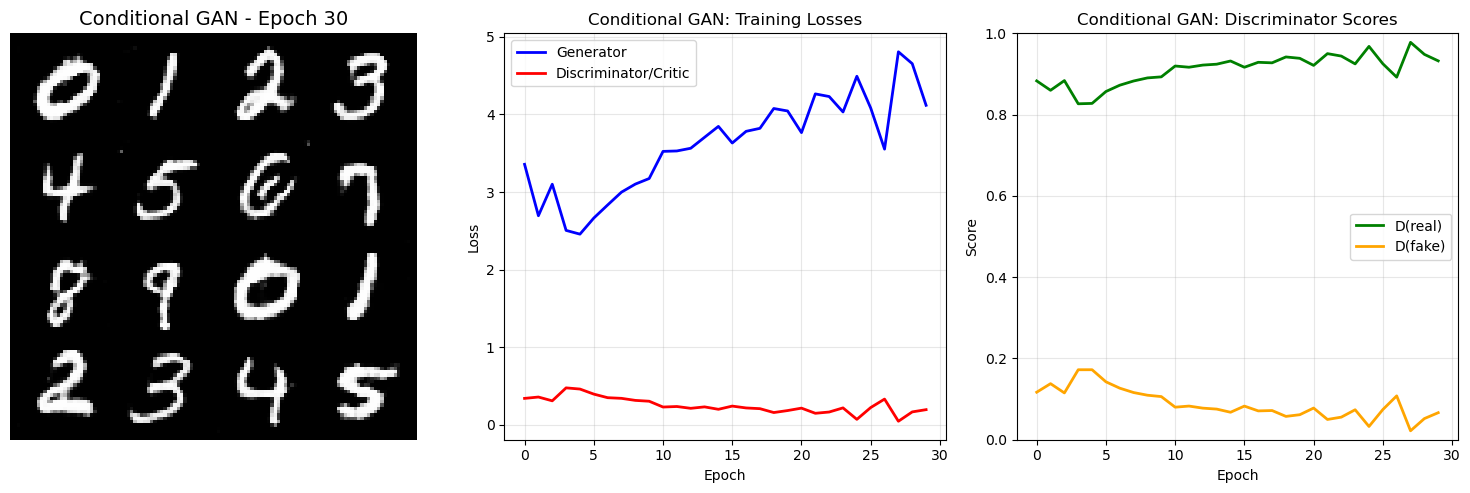

Saved Conditional GAN Generator to gan_results/conditional_gan_generator.pth
Saved Conditional GAN Discriminator to gan_results/conditional_gan_discriminator.pth
Conditional GAN training completed and models saved!

ALL GANs TRAINING COMPLETED!


In [12]:
# Train All GANs
print("\n" + "=" * 60)
print("TRAINING ALL GANs")
print("=" * 60)

# Train each GAN
regular_losses = train_regular_gan()
dcgan_losses = train_dcgan()
wgan_losses = train_wgan_gp()
cgan_losses = train_conditional_gan()

print("\n" + "=" * 60)
print("ALL GANs TRAINING COMPLETED!")
print("=" * 60)


COMPARING ALL GANs


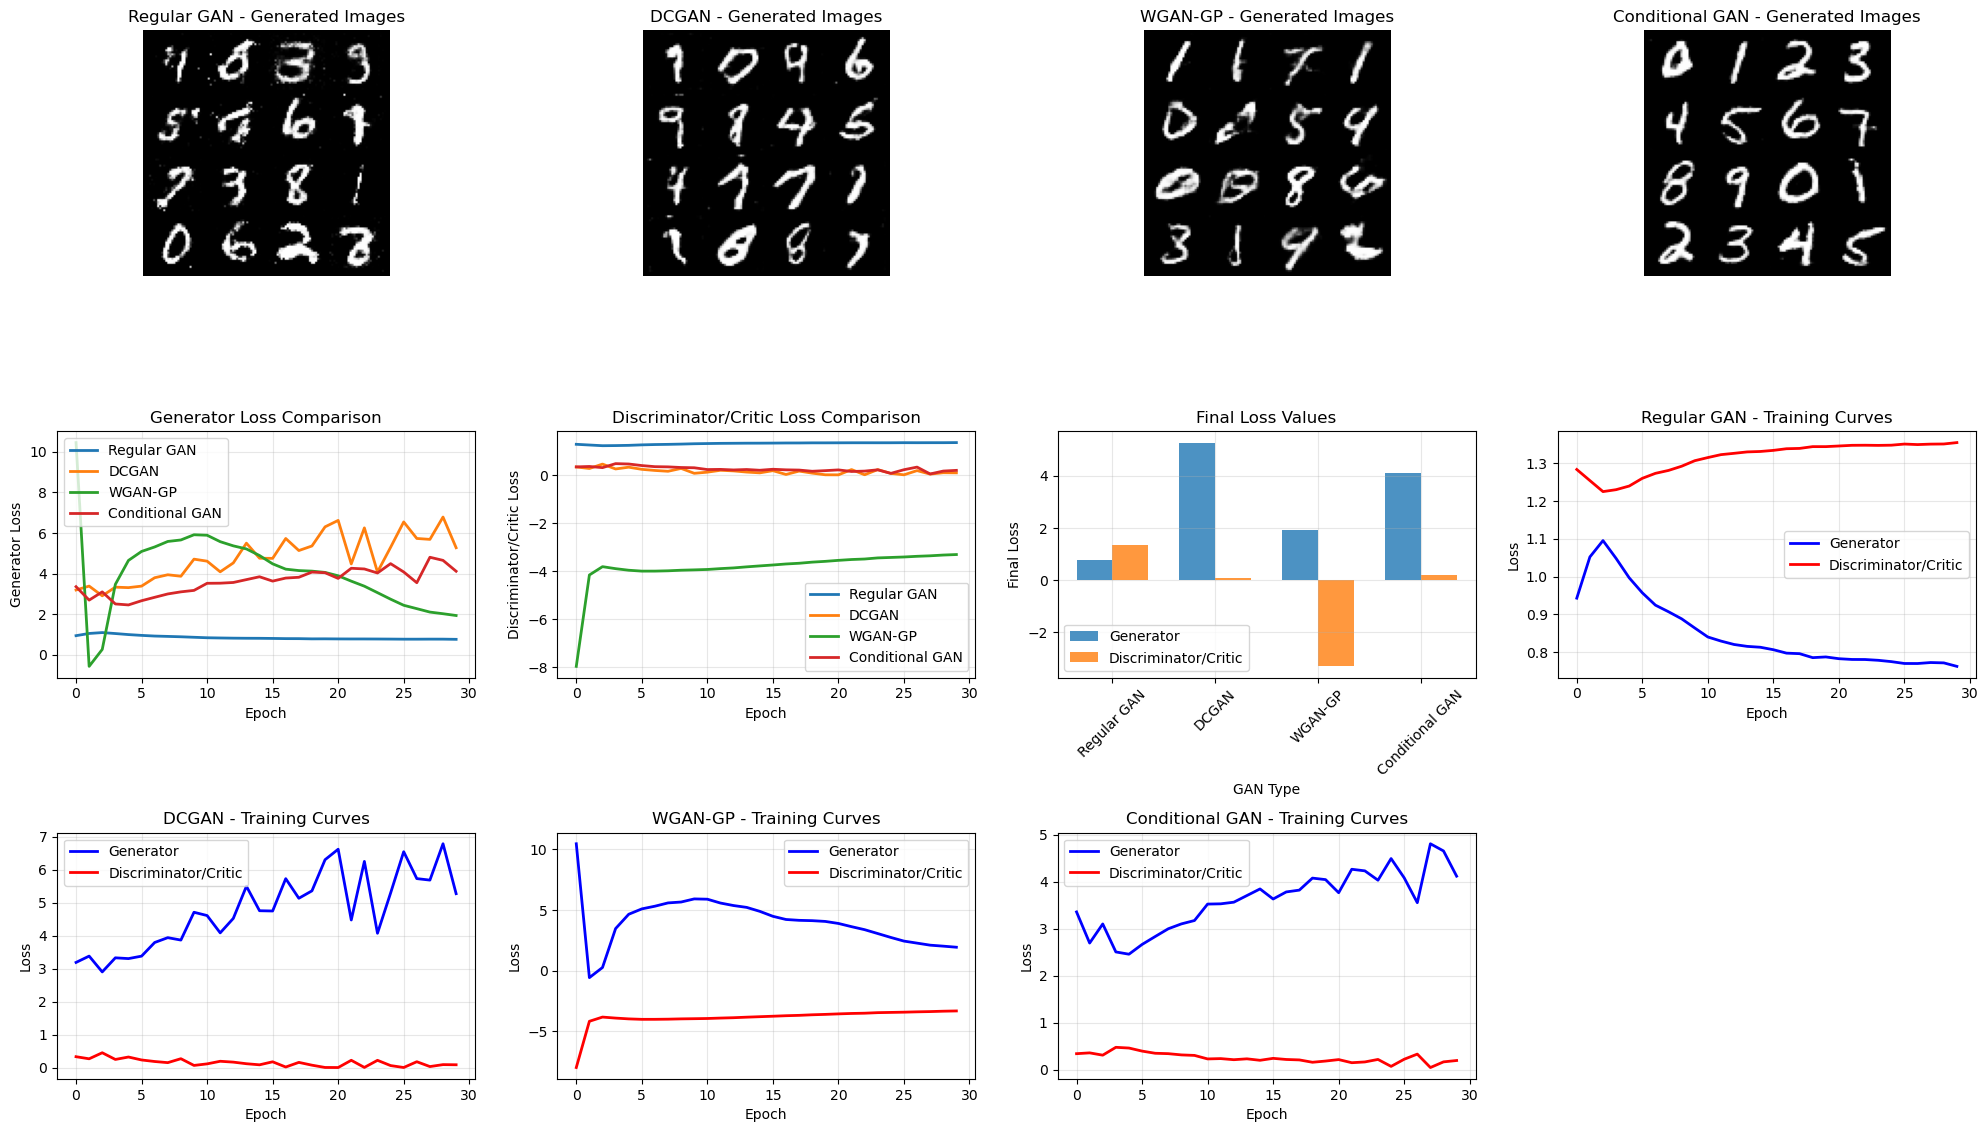


Model Parameter Comparison:
--------------------------------------------------
Regular GAN:
  Generator: 4,395,536 parameters
  Discriminator: 1,460,225 parameters
  Total: 5,855,761 parameters

DCGAN:
  Generator: 765,696 parameters
  Discriminator: 659,456 parameters
  Total: 1,425,152 parameters

WGAN-GP:
  Generator: 765,696 parameters
  Discriminator: 659,137 parameters
  Total: 1,424,833 parameters

Conditional GAN:
  Generator: 1,079,796 parameters
  Discriminator: 700,964 parameters
  Total: 1,780,760 parameters



In [13]:
# Comparison Visualization
def compare_all_gans():
    print("\n" + "=" * 50)
    print("COMPARING ALL GANs")
    print("=" * 50)
    
    plt.figure(figsize=(20, 15))
    
    # Generate samples from each GAN
    with torch.no_grad():
        # Regular GAN
        noise = torch.randn(16, NOISE_DIM, device=device)
        regular_samples = regular_gen(noise).view(-1, 1, 28, 28)
        
        # DCGAN
        dcgan_samples = dcgan_gen(noise)
        
        # WGAN-GP
        wgan_samples = wgan_gen(noise)
        
        # Conditional GAN (generate digits 0-9)
        cgan_noise = torch.randn(16, NOISE_DIM, device=device)
        cgan_labels = torch.arange(0, 10, device=device).repeat(2)[:16]
        cgan_samples = cgan_gen(cgan_noise, cgan_labels)
    
    # Plot generated images
    samples = [regular_samples, dcgan_samples, wgan_samples, cgan_samples]
    titles = ["Regular GAN", "DCGAN", "WGAN-GP", "Conditional GAN"]
    
    for i, (sample, title) in enumerate(zip(samples, titles)):
        plt.subplot(4, 4, i + 1)
        grid = make_grid(sample, nrow=4, normalize=True, value_range=(-1, 1))
        grid = grid.cpu().detach()
        plt.imshow(grid.permute(1, 2, 0))
        plt.title(f"{title} - Generated Images", fontsize=12)
        plt.axis('off')
    
    # Plot training losses
    all_losses = [regular_losses, dcgan_losses, wgan_losses, cgan_losses]
    
    # Generator losses
    plt.subplot(4, 4, 5)
    for i, (losses, title) in enumerate(zip(all_losses, titles)):
        plt.plot(losses[0], label=title, linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.title('Generator Loss Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Discriminator losses
    plt.subplot(4, 4, 6)
    for i, (losses, title) in enumerate(zip(all_losses, titles)):
        plt.plot(losses[1], label=title, linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator/Critic Loss')
    plt.title('Discriminator/Critic Loss Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Final loss values comparison
    plt.subplot(4, 4, 7)
    final_g_losses = [losses[0][-1] for losses in all_losses]
    final_d_losses = [losses[1][-1] for losses in all_losses]
    
    x = np.arange(len(titles))
    width = 0.35
    
    plt.bar(x - width/2, final_g_losses, width, label='Generator', alpha=0.8)
    plt.bar(x + width/2, final_d_losses, width, label='Discriminator/Critic', alpha=0.8)
    plt.xlabel('GAN Type')
    plt.ylabel('Final Loss')
    plt.title('Final Loss Values')
    plt.xticks(x, titles, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Individual loss plots for each GAN
    for i, (losses, title) in enumerate(zip(all_losses, titles)):
        plt.subplot(4, 4, 8 + i)
        plt.plot(losses[0], label='Generator', color='blue', linewidth=2)
        plt.plot(losses[1], label='Discriminator/Critic', color='red', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{title} - Training Curves')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Model parameter comparison
    print("\nModel Parameter Comparison:")
    print("-" * 50)
    models = [
        ("Regular GAN", regular_gen, regular_disc),
        ("DCGAN", dcgan_gen, dcgan_disc),
        ("WGAN-GP", wgan_gen, wgan_critic),
        ("Conditional GAN", cgan_gen, cgan_disc)
    ]
    
    for name, gen, disc in models:
        gen_params = sum(p.numel() for p in gen.parameters())
        disc_params = sum(p.numel() for p in disc.parameters())
        total_params = gen_params + disc_params
        print(f"{name}:")
        print(f"  Generator: {gen_params:,} parameters")
        print(f"  Discriminator: {disc_params:,} parameters")
        print(f"  Total: {total_params:,} parameters")
        print()

# Run comparison
compare_all_gans()


In [14]:
# Gradio Interface Setup with Model Loading
def create_gradio_interface():
    
    # Global variables to store loaded models
    loaded_models = {
        'regular_gen': None,
        'dcgan_gen': None, 
        'wgan_gen': None,
        'cgan_gen': None
    }
    
    def load_all_models():
        print("Loading trained models...")
        
        # Load Regular GAN
        loaded_models['regular_gen'], _ = load_model_complete(
            'gan_results/regular_gan_generator.pth', 
            BasicGenerator, 
            device
        )
        
        # Load DCGAN
        loaded_models['dcgan_gen'], _ = load_model_complete(
            'gan_results/dcgan_generator.pth', 
            DCGANGenerator, 
            device
        )
        
        # Load WGAN-GP
        loaded_models['wgan_gen'], _ = load_model_complete(
            'gan_results/wgan_gp_generator.pth', 
            WGANGenerator, 
            device
        )
        
        # Load Conditional GAN
        loaded_models['cgan_gen'], _ = load_model_complete(
            'gan_results/conditional_gan_generator.pth', 
            ConditionalGenerator, 
            device
        )
        
        print("Models loaded successfully!")
    
    # Load models immediately
    load_all_models()
    
    def generate_regular_gan(num_samples):
        if loaded_models['regular_gen'] is None:
            return None, "Regular GAN model not found. Please train the model first."
        
        try:
            with torch.no_grad():
                noise = torch.randn(num_samples, NOISE_DIM, device=device)
                images = loaded_models['regular_gen'](noise).view(-1, 1, 28, 28)
                return save_tensor_as_image(images, f'gan_results/regular_gan_samples.png'), "Generated successfully!"
        except Exception as e:
            return None, f"Error: {str(e)}"
    
    def generate_dcgan(num_samples):
        if loaded_models['dcgan_gen'] is None:
            return None, "DCGAN model not found. Please train the model first."
        
        try:
            with torch.no_grad():
                noise = torch.randn(num_samples, NOISE_DIM, device=device)
                images = loaded_models['dcgan_gen'](noise)
                return save_tensor_as_image(images, f'gan_results/dcgan_samples.png'), "Generated successfully!"
        except Exception as e:
            return None, f"Error: {str(e)}"
    
    def generate_wgan_gp(num_samples):
        if loaded_models['wgan_gen'] is None:
            return None, "WGAN-GP model not found. Please train the model first."
        
        try:
            with torch.no_grad():
                noise = torch.randn(num_samples, NOISE_DIM, device=device)
                images = loaded_models['wgan_gen'](noise)
                return save_tensor_as_image(images, f'gan_results/wgan_gp_samples.png'), "Generated successfully!"
        except Exception as e:
            return None, f"Error: {str(e)}"
    
    def generate_conditional_gan(digit, num_samples):
        if loaded_models['cgan_gen'] is None:
            return None, "Conditional GAN model not found. Please train the model first."
        
        try:
            with torch.no_grad():
                noise = torch.randn(num_samples, NOISE_DIM, device=device)
                labels = torch.full((num_samples,), digit, dtype=torch.long, device=device)
                images = loaded_models['cgan_gen'](noise, labels)
                return save_tensor_as_image(images, f'gan_results/conditional_gan_digit_{digit}.png'), f"Generated {num_samples} samples of digit {digit}!"
        except Exception as e:
            return None, f"Error: {str(e)}"
    
    def generate_all_digits():
        if loaded_models['cgan_gen'] is None:
            return None, "Conditional GAN model not found. Please train the model first."
        
        try:
            with torch.no_grad():
                all_images = []
                for digit in range(10):
                    noise = torch.randn(1, NOISE_DIM, device=device)
                    label = torch.tensor([digit], device=device)
                    image = loaded_models['cgan_gen'](noise, label)
                    all_images.append(image)
                
                all_images = torch.cat(all_images, dim=0)
                grid = make_grid(all_images, nrow=5, normalize=True, value_range=(-1, 1))
                grid = grid.cpu().detach()
                grid_np = grid.permute(1, 2, 0).numpy()
                grid_np = (grid_np * 255).astype(np.uint8)
                img = Image.fromarray(grid_np)
                img.save('gan_results/all_digits.png')
                return img, "Generated all digits (0-9)!"
        except Exception as e:
            return None, f"Error: {str(e)}"
    
    def compare_gans():
        try:
            available_models = [m for m in loaded_models.values() if m is not None]
            if len(available_models) == 0:
                return None, "No models found. Please train the models first."
            
            with torch.no_grad():
                noise = torch.randn(9, NOISE_DIM, device=device)
                all_images = []
                model_names = []
                
                # Generate from each available GAN
                if loaded_models['regular_gen'] is not None:
                    regular_images = loaded_models['regular_gen'](noise).view(-1, 1, 28, 28)
                    all_images.append(regular_images)
                    model_names.append("Regular GAN")
                
                if loaded_models['dcgan_gen'] is not None:
                    dcgan_images = loaded_models['dcgan_gen'](noise)
                    all_images.append(dcgan_images)
                    model_names.append("DCGAN")
                
                if loaded_models['wgan_gen'] is not None:
                    wgan_images = loaded_models['wgan_gen'](noise)
                    all_images.append(wgan_images)
                    model_names.append("WGAN-GP")
                
                if loaded_models['cgan_gen'] is not None:
                    # For conditional GAN, use first 9 digits
                    cgan_labels = torch.arange(9, device=device)
                    cgan_images = loaded_models['cgan_gen'](noise, cgan_labels)
                    all_images.append(cgan_images)
                    model_names.append("Conditional GAN")
                
                if all_images:
                    # Create comparison grid
                    all_images = torch.cat(all_images, dim=0)
                    grid = make_grid(all_images, nrow=9, normalize=True, value_range=(-1, 1))
                    grid = grid.cpu().detach()
                    grid_np = grid.permute(1, 2, 0).numpy()
                    grid_np = (grid_np * 255).astype(np.uint8)
                    img = Image.fromarray(grid_np)
                    img.save('gan_results/comparison.png')
                    return img, f"Compared {len(model_names)} models: {', '.join(model_names)}"
                else:
                    return None, "No images could be generated."
        except Exception as e:
            return None, f"Error: {str(e)}"
    
    def reload_models():
        load_all_models()
        status = []
        for name, model in loaded_models.items():
            status.append(f"{name}: {'Loaded' if model is not None else 'Not Loaded'}")
        return f"Model Status:\n{chr(10).join(status)}"
    
    # Create Gradio interface
    with gr.Blocks(title="GAN Comparison Demo", theme=gr.themes.Soft()) as demo:
        gr.Markdown("# GAN Comparison Interactive Demo")
        gr.Markdown("Compare different GAN architectures trained on MNIST dataset")
        
        # Model status section
        with gr.Row():
            with gr.Column(scale=3):
                gr.Markdown("### Model Status")
                model_status = gr.Textbox(value=reload_models(), label="Loaded Models", interactive=False)
            with gr.Column(scale=1):
                reload_btn = gr.Button("Reload Models", variant="secondary")
                reload_btn.click(reload_models, outputs=model_status)
        
        with gr.Tabs():
            # Regular GAN Tab
            with gr.Tab("Regular GAN"):
                gr.Markdown("### Basic fully-connected GAN")
                with gr.Row():
                    regular_samples = gr.Slider(1, 16, value=9, step=1, label="Number of samples")
                    regular_btn = gr.Button("Generate", variant="primary")
                with gr.Row():
                    regular_output = gr.Image(label="Generated Images")
                    regular_status = gr.Textbox(label="Status", interactive=False)
                regular_btn.click(generate_regular_gan, inputs=regular_samples, outputs=[regular_output, regular_status])
            
            # DCGAN Tab
            with gr.Tab("DCGAN"):
                gr.Markdown("### Deep Convolutional GAN")
                with gr.Row():
                    dcgan_samples = gr.Slider(1, 16, value=9, step=1, label="Number of samples")
                    dcgan_btn = gr.Button("Generate", variant="primary")
                with gr.Row():
                    dcgan_output = gr.Image(label="Generated Images")
                    dcgan_status = gr.Textbox(label="Status", interactive=False)
                dcgan_btn.click(generate_dcgan, inputs=dcgan_samples, outputs=[dcgan_output, dcgan_status])
            
            # WGAN-GP Tab
            with gr.Tab("WGAN-GP"):
                gr.Markdown("### Wasserstein GAN with Gradient Penalty")
                with gr.Row():
                    wgan_samples = gr.Slider(1, 16, value=9, step=1, label="Number of samples")
                    wgan_btn = gr.Button("Generate", variant="primary")
                with gr.Row():
                    wgan_output = gr.Image(label="Generated Images")
                    wgan_status = gr.Textbox(label="Status", interactive=False)
                wgan_btn.click(generate_wgan_gp, inputs=wgan_samples, outputs=[wgan_output, wgan_status])
            
            # Conditional GAN Tab
            with gr.Tab("Conditional GAN"):
                gr.Markdown("### Conditional GAN - Control the digit!")
                with gr.Row():
                    with gr.Column():
                        cgan_digit = gr.Slider(0, 9, value=7, step=1, label="Digit to generate")
                        cgan_samples = gr.Slider(1, 16, value=9, step=1, label="Number of samples")
                        cgan_btn = gr.Button("Generate Specific Digit", variant="primary")
                    with gr.Column():
                        all_digits_btn = gr.Button("Generate All Digits (0-9)", variant="secondary")
                
                with gr.Row():
                    cgan_output = gr.Image(label="Generated Images")
                    cgan_status = gr.Textbox(label="Status", interactive=False)
                
                cgan_btn.click(generate_conditional_gan, inputs=[cgan_digit, cgan_samples], outputs=[cgan_output, cgan_status])
                all_digits_btn.click(generate_all_digits, outputs=[cgan_output, cgan_status])
            
            # Comparison Tab
            with gr.Tab("Compare All"):
                gr.Markdown("### Side-by-side comparison of all GANs")
                gr.Markdown("Shows 9 samples from each available GAN type")
                compare_btn = gr.Button("Generate Comparison", variant="primary", size="lg")
                with gr.Row():
                    compare_output = gr.Image(label="GAN Comparison")
                    compare_status = gr.Textbox(label="Status", interactive=False)
                compare_btn.click(compare_gans, outputs=[compare_output, compare_status])
        
        # model information
        with gr.Accordion("Model Information", open=False):
            gr.Markdown("""
            ### Model Architectures:
            
            **Regular GAN**: Fully connected layers with batch normalization
            - Simple MLP-based architecture
            - Good baseline but limited image quality
            
            **DCGAN**: Deep Convolutional GAN
            - Uses convolutional and transposed convolutional layers
            - Better spatial structure preservation
            - Higher quality images
            
            **WGAN-GP**: Wasserstein GAN with Gradient Penalty
            - More stable training with Wasserstein distance
            - Gradient penalty for Lipschitz constraint
            - Often produces highest quality results
            
            **Conditional GAN**: Class-conditional generation
            - Can generate specific digits on command
            - Uses label embeddings for conditioning
            - Controllable generation
            """)
    
    return demo


In [15]:
# Launch Gradio Interface
print("\n" + "=" * 50)
print("CREATING GRADIO INTERFACE")
print("=" * 50)

# Create and launch the Gradio interface
demo = create_gradio_interface()

print("Gradio interface created!")


CREATING GRADIO INTERFACE
Loading trained models...
Models loaded successfully!
Loading trained models...
Models loaded successfully!
Gradio interface created!


/tmp/ipykernel_6454/2386900943.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location=device)


In [16]:
# Launch the Interface
if __name__ == "__main__":
    # Launch the Gradio interface
    demo.launch(
        share=True,
        server_name="0.0.0.0",
        server_port=7860,
        show_error=True
    )
    
    print("\n" + "=" * 60)
    print("GRADIO INTERFACE LAUNCHED!")
    print("=" * 60)

* Running on local URL:  http://0.0.0.0:7860
* Running on public URL: https://709ceecb5008778264.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



GRADIO INTERFACE LAUNCHED!
Loading trained models...
Models loaded successfully!


/tmp/ipykernel_6454/2386900943.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location=device)
